In [2]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from scipy.signal import boxcar, hamming, hann
import math

In [3]:
y, sr = librosa.load("piano5.wav")
print(sr)
print(len(y))  #y = duratata semnal in secunde * rata de esantionare sr

22050
26103


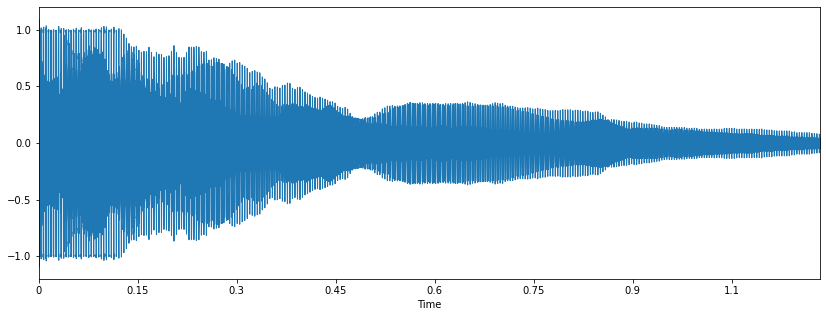

In [4]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(y, sr=sr)

In [5]:
#Esantionare semnal
fereastra = int(80*1e-3*sr)
print(fereastra)

1764


In [6]:
#Ferestre suprapuse
#Factorul de suprapunere
p=0.2
#Numar cadre suprapuse
numar_cadre_p = int(len(y)/(fereastra*(1-p)))
print("Numarul de cadre este %d" %numar_cadre_p)

Numarul de cadre este 18


In [7]:
#Functie de autocorelatie
def autocorelatie(cadru_input):
    lung_sample = len(cadru_input)
    autocor = np.zeros(lung_sample)
    for m in range(lung_sample):
        for j in range(lung_sample-m):
            autocor[m] += cadru_input[j]*cadru_input[j+m]
    return 1/lung_sample*autocor

In [8]:
def frecv_fundam_3(sample, sampling_frequency, max_F0):
    local_max = [sample[0]]
    local_max_ind = [0]
    index = [0]
    min_peak_distance = sampling_frequency//max_F0
    for i in range(1, len(sample)-1):
        if(sample[i]>sample[i-1]) and (sample[i]>sample[i+1]):
            #Stocam valorile si indecsii maximelor locale
            local_max_ind.append(i)
            local_max.append(sample[i])
        #Parcurgem restul maximelor si il determinam pe urmatorul
        #cu valoarea cea mai mare dupa cel din origine
    i = 1
    while i < len(local_max):
        next_max = np.argmax(local_max[i:])
        if local_max_ind[i+next_max] - local_max_ind[i-1] > min_peak_distance:
            index.append(local_max_ind[next_max+i])
        i = i+next_max+1
    return index

In [9]:
midi_hi = 108.0
midi_lo = 12.0
f_hi = librosa.midi_to_hz(midi_hi)
f_lo = librosa.midi_to_hz(midi_lo)
t_lo = sr/f_hi
t_hi = sr/f_lo
print(f_lo, f_hi)
print(t_lo, t_hi)

16.351597831287414 4186.009044809578
5.267547146688752 1348.4920695523206


In [10]:
def note_index_to_note_octave(note_index):
        notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

        note = (note_index - 1) % len(notes)
        note = notes[note]

        octave = (note_index + 8) // len(notes)

        return note, octave

In [11]:
def freq_to_note_index(freq):
        if not freq:  # no log value for 0
            freq += 1e-15
        # formula taken from https://en.wikipedia.org/wiki/Piano_key_frequencies
        note_index = 12 * math.log2(freq / 440) + 49
        offset_from_note = note_index
        note_index = round(note_index)
        offset_from_note -= note_index
        nota = note_index_to_note_octave(note_index)
        return nota

In [16]:
#Creare variabila timp pentru axa Ox
time_axis = np.arange(0, fereastra)*1/sr

for k in range(numar_cadre_p):
    #Extragem doar un cadru din semnal
    cadru_curent_p = y[int(fereastra*k*(1-p)):int(fereastra*(k*(1-p)+1))]

    #Plot ferestre
    #plt.figure(figsize=(14,5))
    #plt.plot(time_axis, cadru_curent_p)
    #plt.title("Cadru de analiza: %d" %(k+1))
    #plt.xlabel("Time [sec]")
    #plt.xlim((0, time_axis[-1]))
    #plt.ylim((-1,1))
    
    #Generare fereastra Hamming
    fereastra_hamming = hamming(fereastra)
    #Inmultesc fereastra hamming cu fiecare cadru in parte
    cadru_hamming = np.multiply(fereastra_hamming, cadru_curent_p)

    #Plot fereastra Hamming
    #plt.figure(figsize=(14,5))
    #plt.plot(time_axis, cadru_hamming, 'y')
    #plt.title('Cadru Hamming')
    #plt.xlabel("Time [sec]")
    #plt.xlim((0, time_axis[-1]))
    #plt.ylim((-1,1))
    
    #Aplicare autocorelatie
    cadru_autocor = autocorelatie(cadru_hamming)
    
    index = frecv_fundam_3(cadru_autocor, sr, 4186)
    
    #plt.figure(figsize=(14,5))
    #plt.plot(time_axis, cadru_autocor)
    #plt.title('Autocorelatie pentru cadrul %d si frecventa fundamentala' %(k+1))
    #plt.vlines(index, min(cadru_autocor), max(cadru_autocor), 'r')
    
    #cadru_autocor[:int(t_lo)] = 0
    #cadru_autocor[int(t_hi):] = 0
    #t_max = cadru_autocor.argmax()
    #pitch = float(sr)/t_max
    #print(pitch)
    
    difs = [x-index[i-1] for i,x in enumerate(index)][1:]
    average_dist = np.mean(difs[:6])
    
    #Convertim in Hz
    err = 2
    F0 = sr/average_dist
    freq = freq_to_note_index(F0)
    freq = ''.join(map(str, freq))
    print("\nFrecventa fundamenta pentru cadrul %d este: %.2f Hz \n" %(k,F0), freq)


Frecventa fundamenta pentru cadrul 0 este: 263.02 Hz 
 C4

Frecventa fundamenta pentru cadrul 1 este: 263.02 Hz 
 C4

Frecventa fundamenta pentru cadrul 2 este: 263.02 Hz 
 C4

Frecventa fundamenta pentru cadrul 3 este: 263.55 Hz 
 C4

Frecventa fundamenta pentru cadrul 4 este: 263.55 Hz 
 C4


KeyboardInterrupt: 